<div class="alert alert-block alert-success">
This is a simple introduction to feature extraction from text to be used for a neural network model. Most neural network algorithms can’t take in straight text, so we will create a matrix of numerical values to represent our text. We’ll do this in two different ways: CountVectorizer and TfidfVectorizer.
</div>

## **Import the needed packages**

In [189]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Roy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Roy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Load the dataset**

In [190]:
#-- The BBC dataset
df = pd.read_csv('articles.csv')

#-- let's look at some of the data
print("Number of rows : " + str(df.shape[0]))
df.sample(10)

Number of rows : 2225


,text,Label
31,Five million Germans out of work\n\nGermany's ...,Business
2052,Virus poses as Christmas e-mail\n\nSecurity fi...,Technology
97,Japan turns to beer alternatives\n\nJapanese b...,Business
1450,Player burn-out worries Robinson\n\nEngland co...,Sports
881,Oscars steer clear of controversy\n\nThe Oscar...,Entertainment
1058,Borders rail link campaign rally\n\nCampaigner...,Politics
73,GM issues 2005 profits warning\n\nGeneral Moto...,Business
2202,The future in your pocket\n\nIf you are a geek...,Technology
1545,Holmes secures comeback victory\n\nBritain's K...,Sports
433,Millions 'to lose textile jobs'\n\nMillions of...,Business


In [191]:
#-- let's keep the data we want
abstract_df = pd.DataFrame(columns=['text', 'word_count'])
abstract_df['text'] = df['text']
#abstract_df.reset_index(inplace = True)
abstract_df['word_count'] = abstract_df['text'].apply(lambda x: len(x.split(" ")))
total_wordcount = abstract_df['word_count'].sum()
print("sum \t" + str(total_wordcount))
print(abstract_df.word_count.describe())
abstract_df.head()

sum 	844153
count    2225.000000
mean      379.394607
std       235.104259
min        87.000000
25%       243.000000
50%       327.000000
75%       465.000000
max      4377.000000
Name: word_count, dtype: float64


,text,word_count
0,UK economy facing 'major risks'\n\nThe UK manu...,319
1,Aids and climate top Davos agenda\n\nClimate c...,442
2,Asian quake hits European shares\n\nShares in ...,539
3,India power shares jump on debut\n\nShares in ...,171
4,Lacroix label bought by US firm\n\nLuxury good...,148


In [192]:
#-- let's look at the most common words before cleaning the data
raw_word_counts = pd.Series(''.join(abstract_df['text']).split()).value_counts()
raw_word_counts

the          44482
to           24782
of           19833
and          17904
a            17135
             ...  
"tortured        1
refered          1
missing,"        1
Everquest        1
NGOs             1
Length: 65553, dtype: int64

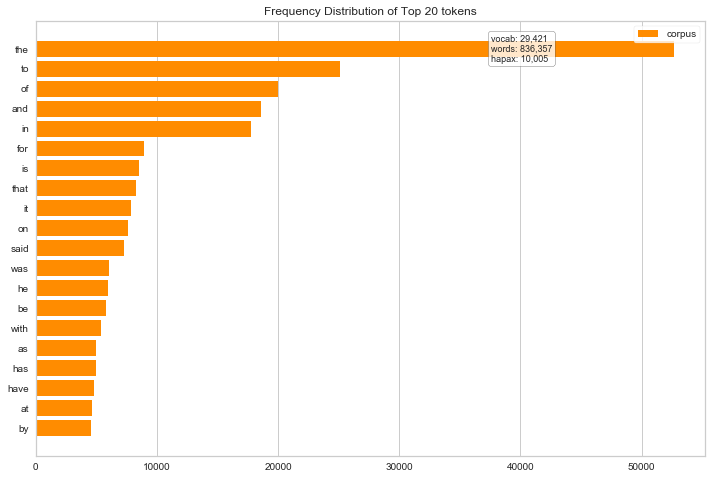

In [193]:
#-- Let's look at them through graph
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df['text'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features, n = 20, color = 'darkorange')
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

## **Clean our dataset**
To clean our data, we need to do the following:
* remove punctuation and special symbols
* remove tags
* remove digits
* make all characters lower case
* remove all stopwords
* get the lemmas for our words (lemmatization)

In [194]:
corpus = []
#-- initialize the lemmatizer
lem = WordNetLemmatizer()
#-- create a set of stopwords
stop_words = set(stopwords.words("english"))
for text in abstract_df['text']:
    #-- remove all punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    #-- empty tags 
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    #-- remove special characters and digits
    text = re.sub("(\\d|\\W)+"," ", text)
    #-- make all chars lowercase
    text.lower()
    #-- create a list of words 
    words = text.split()
    text = " ".join([lem.lemmatize(word) for word in words if \
                    word not in stop_words])
    corpus.append(text)
#-- We've now generated a normalized corpus with only word lemmas
corpus[:2]

['UK economy facing major risk The UK manufacturing sector continue face serious challenge next two year British Chamber Commerce BCC said The group quarterly survey company found export picked last three month best level eight year The rise came despite exchange rate cited major concern However BCC found whole UK economy still faced major risk warned growth set slow It recently forecast economic growth slow little Manufacturers domestic sale growth fell back slightly quarter survey firm found Employment manufacturing also fell job expectation lowest level year Despite positive news export sector worrying sign manufacturing BCC said These result reinforce concern sector persistent inability sustain recovery The outlook service sector uncertain despite increase export order quarter BCC noted The BCC found confidence increased quarter across manufacturing service sector although overall failed reach level start The reduced threat interest rate increase contributed improved confidence sai

Text(0.5, 1.0, 'Word Frequency')

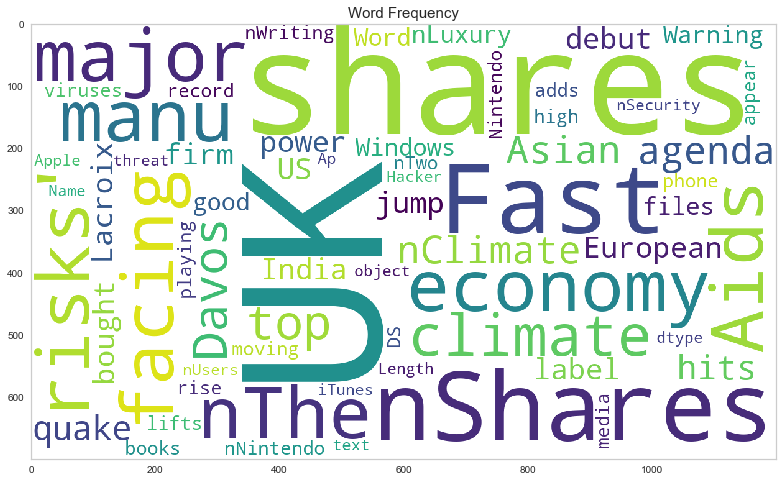

In [195]:
#-- word cloud after the processing
wordcloud = WordCloud(background_color = 'white',
                      width = 1200,
                      height = 700).generate(str(df['text']))

plt.figure(figsize = (14, 8))
plt.imshow(wordcloud)
plt.grid(False)
#plt.axis('off')
plt.title("Word Frequency", fontsize = 15)

## **Create the count vector**

In [196]:
#-- Count vector
cv = CountVectorizer(stop_words= stop_words, max_features = 10000, ngram_range= (1,1))

#-- loading the corpus into the CountVectorizer
cv = cv.fit(corpus)
cv.get_feature_names()[:10]

['aaa',
 'aaas',
 'aaron',
 'abandoned',
 'abandoning',
 'abandonment',
 'abba',
 'abbas',
 'abbasi',
 'abbott']

In [197]:
##-- Let's tranform CV object
frequency_matrix = cv.transform(corpus)
frequency_matrix

<2225x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 306856 stored elements in Compressed Sparse Row format>

In [198]:
sum_words = frequency_matrix.sum(axis = 0)
word_frequencies = [(word, sum_words[0,idx]) for word, idx in cv.vocabulary_.items()]
word_frequencies = sorted(word_frequencies, key = lambda x: x[1], reverse = True)
word_frequencies[:10]

[('said', 7255),
 ('year', 3310),
 ('mr', 3005),
 ('would', 2581),
 ('also', 2156),
 ('people', 2046),
 ('new', 1978),
 ('one', 1942),
 ('us', 1713),
 ('time', 1539)]

In [199]:
#-- Let's create document term matrix
dtm = cv.transform(corpus)
repr(dtm)
print(dtm)

  (0, 87)	1
  (0, 298)	1
  (0, 303)	1
  (0, 326)	1
  (0, 608)	1
  (0, 668)	1
  (0, 711)	1
  (0, 769)	6
  (0, 858)	1
  (0, 1126)	1
  (0, 1274)	1
  (0, 1442)	1
  (0, 1446)	1
  (0, 1553)	1
  (0, 1721)	1
  (0, 1751)	1
  (0, 1810)	2
  (0, 1833)	3
  (0, 1903)	2
  (0, 1932)	1
  (0, 1946)	1
  (0, 2011)	1
  (0, 2225)	1
  (0, 2428)	3
  (0, 2521)	1
  :	:
  (2224, 6782)	1
  (2224, 6915)	3
  (2224, 6946)	2
  (2224, 7265)	1
  (2224, 7721)	1
  (2224, 7819)	1
  (2224, 7932)	3
  (2224, 7951)	1
  (2224, 8172)	1
  (2224, 8298)	1
  (2224, 8326)	1
  (2224, 8349)	1
  (2224, 8577)	1
  (2224, 9033)	2
  (2224, 9266)	1
  (2224, 9424)	1
  (2224, 9459)	2
  (2224, 9461)	2
  (2224, 9494)	4
  (2224, 9495)	2
  (2224, 9552)	3
  (2224, 9747)	1
  (2224, 9840)	1
  (2224, 9841)	1
  (2224, 9903)	1


In [200]:
#-- Let's convert the sparse matrix into a dataframe
pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names())

,aaa,aaas,aaron,abandoned,abandoning,abandonment,abba,abbas,abbasi,abbott,...,zen,zeppelin,zero,zhang,zimbabwe,zoe,zombie,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **Using TF-IDF**

It's an alternative to CountVectorizer and creates a document term matrix from the texts.

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer

#-- function to create document term matrix
def createDTM(text):
    vect = TfidfVectorizer()
    dtm = vect.fit_transform(text)
    #-- create pandas dataframe of DTM
    return pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

#-- let's take a look at the dtm
createDTM(corpus)

,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aan,aara,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.049918,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Reference:
* https://www.searchtechnologies.com/blog/natural-language-processing-techniques
* https://sanjayasubedi.com.np/nlp/nlp-feature-extraction
* https://github.com/henchc/NLP-Feature-Extraction/blob/master/NLP-Feature-Extraction.ipynb